Hello! Here you can find how to implement GNN and how to use it for RecSys.
We will recommend music to users
using [MAGNN architecture](https://arxiv.org/pdf/2002.01680.pdf) and [LastFM dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.LastFM.html).
Specifically, the model will be used for "link prediction" task by using collaborative filtering.

First of all, let's import everything for the work.

In [27]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.datasets import LastFM

from sklearn.metrics import average_precision_score, roc_auc_score
from tqdm import tqdm

from collections import defaultdict

In [28]:
np.random.seed(1337)
torch.manual_seed(1337)

In [29]:
NUM_USERS = 1892
NUM_MOVIES = 17632
BATCH_SIZE = 64

num_user_features = 1
num_movie_features = 1

device = "cuda" if torch.cuda.is_available() else "cpu"

Let's extract the dataset and create a new feature for it. We should do it to increase the accuracy of the model in the future. This number represents the similarity or closeness between the two users.
In collaborative filtering, similarity is often measured based on the users' preferences, behaviors, or interactions with items (in this case, probably music tracks on LastFM).
The value between 0 and 1 indicates the degree of similarity, with 1 being a perfect match (users are very similar), and 0 being no similarity.

In [30]:
# Loading initial dataset
dataset = LastFM("data/raw/LastFM")

# Loading preprocessed data
path = "./data/raw/LastFM/raw/"

# Extract features from dataset 
user_sums = defaultdict(lambda: torch.tensor(0))
user_counts = defaultdict(lambda: torch.tensor(0))
with open(path + "user_user(knn).dat") as f:
    for line in f:
        u1, _, w = map(float, line.split())
        u1 = int(u1)
        user_sums[u1] = user_sums[u1] + w
        user_counts[u1] += 1

movie_sums = defaultdict(lambda: torch.tensor(0))
movie_counts = defaultdict(lambda: torch.tensor(0))
with open(path + "artist_artist(knn).dat") as f:
    for line in f:
        u1, _, w = map(float, line.split())
        u1 = int(u1)
        movie_sums[u1] = movie_sums[u1] + w
        movie_counts[u1] += 1

# Take average value
user_features = {i: (user_sums[i] / user_counts[i]).clone().detach() for i in user_sums}
movie_features = {i: (movie_sums[i] / movie_counts[i]).clone().detach() for i in movie_sums}

user_features = defaultdict(lambda: torch.tensor(0), user_features)
movie_features = defaultdict(lambda: torch.tensor(0), movie_features)


In [31]:
dataset = dataset[0]

Now we will preprocess data and then split it to train and validation sets.

In [32]:
edge_index = dataset["user", "to", "artist"]["edge_index"]
train_movie_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[0].unique()):
    neighbors = torch.where((edge_index[0] == i).clone().detach(), edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        train_movie_metapaths[int(path[0])] = np.vstack((train_movie_metapaths[int(path[0])], path))

100%|██████████| 1892/1892 [00:36<00:00, 52.09it/s]


In [33]:
edge_index = dataset["user", "to", "artist"]["test_pos_edge_index"]
test_movie_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[0].unique()):
    neighbors = torch.where((edge_index[0] == i).clone().detach(), edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        test_movie_metapaths[int(path[0])] = np.vstack((test_movie_metapaths[int(path[0])], path))

100%|██████████| 1863/1863 [00:03<00:00, 478.03it/s]


In [34]:
edge_index = dataset["artist", "to", "user"]["edge_index"]
train_user_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[0].unique()):
    neighbors = torch.where((edge_index[0] == i).clone().detach(), edge_index, -1)[1].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        train_user_metapaths[int(path[0])] = np.vstack((train_user_metapaths[int(path[0])], path))

100%|██████████| 17632/17632 [00:59<00:00, 296.35it/s] 


In [35]:
edge_index = dataset["user", "to", "artist"]["test_pos_edge_index"]
test_user_metapaths = defaultdict(lambda: np.zeros(shape=(0, 3)))
for i in tqdm(edge_index[1].unique()):
    neighbors = torch.where((edge_index[1] == i).clone().detach(), edge_index, -1)[0].unique()[1:]
    comb = torch.combinations(neighbors, with_replacement=True)
    col = torch.ones(size=(comb.shape[0], 1)) * i
    meta_paths = torch.hstack((comb[:, :1], col, comb[:, 1:]))
    for path in meta_paths:
        test_user_metapaths[int(path[0])] = np.vstack((test_user_metapaths[int(path[0])], path))

100%|██████████| 4041/4041 [00:08<00:00, 488.62it/s] 


In [36]:
neg_edge_index = dataset["user", "to", "artist"]["train_neg_edge_index"]

train_pos = dataset["user", "to", "artist"]["edge_index"]
train_neg = neg_edge_index[:, :train_pos.shape[1]]

test_pos = dataset["user", "to", "artist"]["test_pos_edge_index"]
test_neg = dataset["user", "to", "artist"]["test_neg_edge_index"][:, :test_pos.shape[1]]

We also might need to do preprocess flow:

In [40]:
class UserMovieDataset(Dataset):
    """Dataset for MAGNN training and evaluation"""

    def __init__(self, positives: torch.Tensor, user_meta_paths: defaultdict, movie_meta_paths: defaultdict,
                 max_user_size: int, max_movie_size: int, negatives=None, benchmark: bool = False):
        self.benchmark = benchmark
        self.max_user_size = max_user_size
        self.max_movie_size = max_movie_size

        self.user_meta_paths = user_meta_paths.copy()
        self.movie_meta_paths = movie_meta_paths.copy()
        self.merge_meta_paths()

        self.pos = positives.numpy()
        self.neg = negatives.numpy()

        self.data = torch.tensor(np.vstack([self.pos.T, self.neg.T]))
        self.labels = torch.vstack([torch.ones((len(self.pos.T), 1)), torch.zeros((len(self.neg.T), 1))])

    def merge_meta_paths(self):
        for key, val in tqdm(self.user_meta_paths.items(), desc="Extracting user meta-paths"):
            if len(self.user_meta_paths[key]) > 0:
                self.user_meta_paths[key] = [torch.vstack([user_features[i] for i in val[:, 0]])[:self.max_user_size],
                                             torch.vstack([movie_features[i] for i in val[:, 1]])[:self.max_user_size],
                                             torch.vstack([user_features[i] for i in val[:, 2]])[:self.max_user_size]]
                while len(self.user_meta_paths[key][0]) < self.max_user_size:
                    self.user_meta_paths[key][0] = torch.vstack(
                        [self.user_meta_paths[key][0], torch.zeros_like(self.user_meta_paths[key][0][0])])
                    self.user_meta_paths[key][1] = torch.vstack(
                        [self.user_meta_paths[key][1], torch.zeros_like(self.user_meta_paths[key][1][0])])
                    self.user_meta_paths[key][2] = torch.vstack(
                        [self.user_meta_paths[key][2], torch.zeros_like(self.user_meta_paths[key][2][0])])

        for key, val in tqdm(self.movie_meta_paths.items(), desc="Extracting movie meta-paths"):
            if len(self.movie_meta_paths[key]) > 0:
                self.movie_meta_paths[key] = [
                    torch.vstack([movie_features[i] for i in val[:, 0]])[:self.max_movie_size],
                    torch.vstack([user_features[i] for i in val[:, 1]])[:self.max_movie_size],
                    torch.vstack([movie_features[i] for i in val[:, 2]])[:self.max_movie_size]]
                while len(self.movie_meta_paths[key][0]) < self.max_movie_size:
                    self.movie_meta_paths[key][0] = torch.vstack(
                        [self.movie_meta_paths[key][0], torch.zeros_like(self.movie_meta_paths[key][0][0])])
                    self.movie_meta_paths[key][1] = torch.vstack(
                        [self.movie_meta_paths[key][1], torch.zeros_like(self.movie_meta_paths[key][1][0])])
                    self.movie_meta_paths[key][2] = torch.vstack(
                        [self.movie_meta_paths[key][2], torch.zeros_like(self.movie_meta_paths[key][2][0])])

    def __getitem__(self, idx):
        user_id, movie_id = self.data[idx]

        if len(self.user_meta_paths[user_id.item()]) == 0:
            key = user_id.item()
            self.user_meta_paths[key] = [torch.Tensor([0]), torch.Tensor([0]), torch.Tensor([0])]
            while len(self.user_meta_paths[key][0]) < self.max_user_size:
                self.user_meta_paths[key][0] = torch.vstack(
                    [self.user_meta_paths[key][0], torch.zeros_like(self.user_meta_paths[key][0][0])])
                self.user_meta_paths[key][1] = torch.vstack(
                    [self.user_meta_paths[key][1], torch.zeros_like(self.user_meta_paths[key][1][0])])
                self.user_meta_paths[key][2] = torch.vstack(
                    [self.user_meta_paths[key][2], torch.zeros_like(self.user_meta_paths[key][2][0])])

        if len(self.movie_meta_paths[movie_id.item()]) == 0:
            key = movie_id.item()
            self.movie_meta_paths[key] = [torch.Tensor([0]), torch.Tensor([0]), torch.Tensor([0])]
            while len(self.movie_meta_paths[key][0]) < self.max_movie_size:
                self.movie_meta_paths[key][0] = torch.vstack(
                    [self.movie_meta_paths[key][0], torch.zeros_like(self.movie_meta_paths[key][0][0])])
                self.movie_meta_paths[key][1] = torch.vstack(
                    [self.movie_meta_paths[key][1], torch.zeros_like(self.movie_meta_paths[key][1][0])])
                self.movie_meta_paths[key][2] = torch.vstack(
                    [self.movie_meta_paths[key][2], torch.zeros_like(self.movie_meta_paths[key][2][0])])

        return self.data[idx], self.labels[idx], *self.user_meta_paths[user_id.item()], *self.movie_meta_paths[
            movie_id.item()]

    def __len__(self):
        return len(self.data)

In [42]:
print("Train Dataset:")
train_dataset = UserMovieDataset(train_pos, train_user_metapaths, train_movie_metapaths, 905, 67, train_neg)
print("Test Dataset:")
test_dataset = UserMovieDataset(test_pos, test_user_metapaths, test_movie_metapaths, 131, 28, test_neg, benchmark=True)

Train Dataset:


Extracting movie meta-paths: 100%|██████████| 17632/17632 [00:38<00:00, 462.16it/s]


Test Dataset:


Extracting movie meta-paths: 100%|██████████| 4041/4041 [00:03<00:00, 1149.22it/s]


In [43]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

So let's implement our model.
We will take a MAGNN for this data. It has many disadvantages:
- it can learn from multiple graphs simultaneously;
- it can model long-range dependencies that many common GNN cannot.

But there is also a disadvantage of the model: it's computationally expensive when we use datasets with a large number of nodes and edges. You will see it a bit later.
Let's look at the architecture closer.

---

## MAGNN workflow ##
Specifically, MAGNN first applies type-specific linear transformations to project heterogeneous node attributes, with possibly unequal dimensions for different node
types, to the same latent vector space. Next, MAGNN applies intra-metapath aggregation with the attention mechanism for every metapath.
During this intrametapath aggregation, each target node extracts and combines information from the metapath instances connecting the node with its metapath-based neighbors.
In this way, MAGNN captures the structural and semantic information of heterogeneous graphs from both neighbor nodes and the metapath context in between.
Following intra-metapath aggregation, MAGNN further conducts intermetapath aggregation using the attention mechanism to fuse latent vectors obtained from
multiple metapaths into final node embeddings. By integrating multiple metapaths, our model can learn the comprehensive semantics ingrained in the heterogeneous graph.

MAGNN is constructed by three major components: node content transformation, intra-metapath aggregation, and inter-metapath aggregation.
Here's an illustration of the embedding generation of a single node:
![](images/workflow.png)

In [44]:
class GraphAttention(nn.Module):
    """Attention layer for encoded metapaths"""

    def __init__(self, hidden_dim: int, num_heads: int, dropout: float):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.query = nn.Linear(hidden_dim, hidden_dim)
        self.key = nn.Linear(hidden_dim, hidden_dim)
        self.value = nn.Linear(hidden_dim, hidden_dim)
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads, dropout=dropout, batch_first=True)

    def forward(self, x: torch.Tensor):
        queries = self.query(x)
        keys = self.key(x)
        values = self.value(x)
        weighted, _ = self.attention(queries, keys, values)
        return weighted


class MetapathEncoder(nn.Module):
    """Inter-metapath aggregator"""

    def __init__(self, in_dim: int, out_dim: int):
        super().__init__()
        self.fc = nn.Linear(in_dim, out_dim)

    def forward(self, metapath):
        x = torch.mean(metapath, dim=1)
        return self.fc(x)


class MAGNN(nn.Module):
    """MAGNN architecture, but simplified for only 1 metapath per node type (due to computing powers limitation)"""

    def __init__(self, num_user_features: int, num_movie_features: int, hidden_dim: int, out_dim: int, num_heads: int, dropout: float, batch_size: int):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size

        self.num_user_features = num_user_features
        self.num_movie_features = num_movie_features

        self.user_feature_encoder = nn.Linear(self.num_user_features, hidden_dim)
        self.movie_feature_encoder = nn.Linear(self.num_movie_features, hidden_dim)

        self.user_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.user_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.movie_metapath_encoder = MetapathEncoder(hidden_dim, hidden_dim)
        self.movie_metapath_attention = GraphAttention(hidden_dim, num_heads, dropout)

        self.user_node_embedding = nn.Linear(hidden_dim, out_dim)
        self.user_dropout = nn.Dropout(dropout)

        self.movie_node_embedding = nn.Linear(hidden_dim, out_dim)  #, dropout)  # TODO тут ведь не Dropout, а bias
        self.movie_dropout = nn.Dropout(dropout)

        self.recommender = nn.Linear(2 * out_dim, 1)

    def forward(self, _, user_metapaths1, user_metapaths2, user_metapaths3, movie_metapaths1, movie_metapaths2, movie_metapaths3):
        """
        Forward propagation of the model.
        
        You can find the pseudocode of the function in the paper that was mentioned in the beginning.
        """
        user_metapath_instance = torch.cat([
            self.user_feature_encoder(user_metapaths1),
            self.movie_feature_encoder(user_metapaths2),
            self.user_feature_encoder(user_metapaths3)
        ], dim=1)
        user_aggregated_metapath = F.tanh(self.user_metapath_encoder(user_metapath_instance))
        user_aggregated_metapath = self.user_metapath_attention(user_aggregated_metapath)

        movie_metapath_instance = torch.cat([
            self.movie_feature_encoder(movie_metapaths1),
            self.user_feature_encoder(movie_metapaths2),
            self.movie_feature_encoder(movie_metapaths3)
        ], dim=1)
        movie_aggregated_metapath = F.tanh(self.movie_metapath_encoder(movie_metapath_instance))
        movie_aggregated_metapath = self.movie_metapath_attention(movie_aggregated_metapath)

        user_embed = self.user_dropout(F.sigmoid(self.user_node_embedding(user_aggregated_metapath)))
        movie_embed = self.movie_dropout(F.sigmoid(self.movie_node_embedding(movie_aggregated_metapath)))

        return F.sigmoid(self.recommender(torch.cat([user_embed, movie_embed], dim=1)))

In [45]:
model = MAGNN(num_user_features, num_movie_features, 128, 128, 8, 0.2, BATCH_SIZE)

To train the model we will use BCELoss and Adam optimizer. All settings you may see below.

In [46]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5, weight_decay=2e-7)

In [47]:
def train(epoch: int):
    losses = []
    accs = []

    model.train()
    progress_bar = tqdm(train_loader, f"Epoch {epoch}")
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
                device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        optimizer.zero_grad()

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE

        losses.append(loss.item())
        accs.append(acc.cpu())

        loss.backward()
        optimizer.step()

        progress_bar.set_description(f"Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}")

    return np.mean(losses)


def validate(epoch: int):
    losses = []
    accs = []

    model.eval()
    progress_bar = tqdm(test_loader)
    for batch in progress_bar:
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
        edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
            edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
                device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

        out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)

        pred = (out > 0.5)

        loss = criterion(out, label)
        acc = (pred == label).sum() / BATCH_SIZE

        losses.append(loss.item())
        accs.append(acc.cpu())

        progress_bar.set_description(f"Validation Epoch {epoch}, Loss: {np.mean(losses):.5f}, Acc: {np.mean(accs):.5f}")

    return np.mean(losses)

In [48]:
torch.cuda.empty_cache()

In [49]:
EPOCHS = 50
train_losses = []
val_losses = []
best_loss = float("inf")
model.to(device)
# TODO почему тут вывод не сохраняется?
for epoch in range(EPOCHS):
    train_loss = train(epoch)
    val_loss = validate(epoch)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print()
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), "./models/best_magnn.pt")

Epoch 0:   0%|          | 0/2031 [00:00<?, ?it/s]

Validation Epoch 0, Loss: 0.49078, Acc: 0.84281: 100%|██████████| 581/581 [00:17<00:00, 33.66it/s] 


Epoch 1, Loss: 0.58588, Acc: 0.72608:  74%|███████▍  | 1508/2031 [00:30<00:10, 49.18it/s]


KeyboardInterrupt: 

FileNotFoundError: [Errno 2] No such file or directory: '../reports/figures/losses.png'

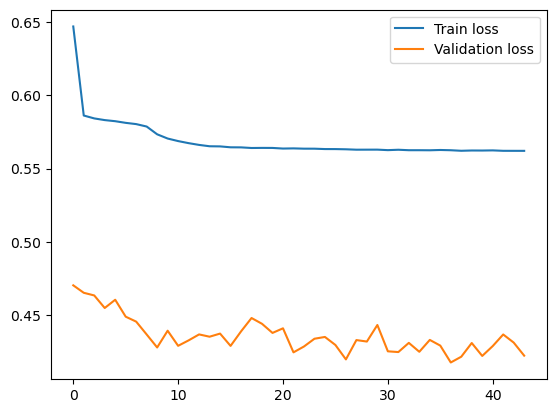

In [ ]:
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.savefig("figures/losses.png")
plt.show()

Well done! The traing is over and the result is stored in the file. Now let's check how it works.

In [ ]:
model = MAGNN(num_user_features, num_movie_features, 128, 128, 8, 0.2, BATCH_SIZE)
model.load_state_dict(torch.load("./models/best_magnn.pt"))

In [ ]:
model.to(device)
model.eval()

maps = []
accs = []
rocs = []

for batch in tqdm(test_loader):
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = batch
    edge, label, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3 = \
        edge.to(device), label.to(device), umetapath1.to(device), umetapath2.to(device), umetapath3.to(
            device), mmetapath1.to(device), mmetapath2.to(device), mmetapath3.to(device)

    out = model(edge, umetapath1, umetapath2, umetapath3, mmetapath1, mmetapath2, mmetapath3)
    pred = (out > 0.5)
    acc = (pred == label.reshape(-1, 1)).sum() / BATCH_SIZE

    accs.append(acc.cpu())
    maps.append(average_precision_score(label.reshape(-1, 1).cpu().detach().numpy(), out.cpu().detach().numpy()))
    rocs.append(roc_auc_score(label.reshape(-1, 1).cpu().detach().numpy(), out.cpu().detach().numpy()))

print(f"mAP: {np.mean(maps)}")
print(f"Accuracy: {np.mean(accs)}")
print(f"ROC-AUC score: {np.mean(rocs)}")

That's it! Try to use your data and find some music for you own:)
If you have any questions, or you want to add something to this tutorial, don't be afraid to text us!